# NCAA Basketball Game Predictor

## Data Curation and Feature Engineering

In [34]:
import os
import numpy as np
import pandas as pd

Team statistics in the NCAA across the 2013-2021 seasons can be found in https://www.kaggle.com/datasets/andrewsundberg/college-basketball-dataset. These statistics are tempo-free statistics, meaning they do not depend on the tempo that a team places at. For our purposes, we will read each season file and compile it into a single dataframe.

In [3]:
# Read in the cbb13-21.csv files and form one large dataframe, and
# create a new column for the year
for i in range(13, 22):
    df = pd.read_csv(f'dataset/cbb{i}.csv')
    df['YEAR'] = 2000 + i
    if i == 13:
        df_team_stats = df
    else:
        df_team_stats = pd.concat([df_team_stats, df])

print(f"Team statistics with {df_team_stats.shape[0]} rows and {df_team_stats.shape[1]} columns.")

df_team_stats

Team statistics with 3155 rows and 25 columns.


,TEAM,CONF,G,W,ADJOE,ADJDE,BARTHAG,EFG_O,EFG_D,TOR,...,2P_O,2P_D,3P_O,3P_D,ADJ_T,WAB,POSTSEASON,SEED,YEAR,RK
0,Indiana,B10,36,29,121.0,89.7,0.9692,54.7,44.0,19.3,...,52.0,43.2,40.3,30.4,67.8,7.8,S16,1.0,2013,NaN
1,Gonzaga,WCC,34,31,118.9,90.2,0.9599,54.9,44.9,17.2,...,55.0,42.1,36.5,32.9,65.1,7.6,R32,1.0,2013,NaN
2,Kansas,B12,37,31,111.6,86.2,0.9514,53.3,41.5,20.3,...,52.9,39.3,36.4,30.3,67.7,7.5,S16,1.0,2013,NaN
3,Louisville,BE,40,35,115.9,84.5,0.9743,50.6,44.8,18.3,...,50.8,43.4,33.3,31.8,67.1,9.0,Champions,1.0,2013,NaN
4,Georgetown,BE,32,25,107.6,85.0,0.9381,51.1,43.0,20.1,...,50.2,41.4,35.3,30.7,62.5,6.6,R64,2.0,2013,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
342,Louisiana Tech,CUSA,27,21,102.7,93.4,0.7479,50.5,45.6,18.4,...,49.7,46.4,34.6,29.6,69.6,-1.7,NaN,NaN,2021,NaN
343,Toledo,MAC,29,21,113.3,101.8,0.7743,54.3,48.3,15.5,...,52.5,51.0,37.7,29.5,69.1,-2.1,NaN,NaN,2021,NaN
344,UAB,CUSA,27,22,102.5,94.6,0.7153,48.6,47.0,15.6,...,49.4,46.1,31.1,32.4,67.5,-2.7,NaN,NaN,2021,NaN
345,Eastern Kentucky,OVC,27,22,101.5,102.3,0.4749,51.2,51.0,16.6,...,49.6,51.8,35.8,33.0,75.1,-3.8,NaN,NaN,2021,NaN


Using `scraper.py`, we collected data on about 60,000 games across the 2013-2021 seasons from https://barttorvik.com/gamestat.php and exported them to `games.csv`. To be more efficient, the scraper does not collect data on every team but rather randomly selects teams in each season.

The venue of the team (Home, Away, Neutral) is a feature that we are interested in incorporating since home court advantage is often observed to be a major contributor to the outcome of a game in sports.

In [4]:
# Read in the data
games_df = pd.read_csv('dataset/games.csv')

print(f"{games_df.shape[0]} games in the dataset.")
games_df

66719 games in the dataset.


,year,date,team1,team2,team1_venue,team1_outcome,team1_score,team2_score
0,2013,11/9/12,Pepperdine,Cal St. Northridge,A,L,75,81
1,2013,11/13/12,Pepperdine,California,A,L,62,79
2,2013,11/16/12,Pepperdine,Washington St.,H,W,58,56
3,2013,11/20/12,Pepperdine,Houston Christian,A,W,57,53
4,2013,11/24/12,Pepperdine,UC Irvine,H,W,72,62
...,...,...,...,...,...,...,...,...
66714,2021,3/3/21,Missouri,Florida,A,W,72,70
66715,2021,3/6/21,Missouri,LSU,H,L,80,86
66716,2021,3/11/21,Missouri,Georgia,N,W,73,70
66717,2021,3/12/21,Missouri,Arkansas,N,L,64,70


Not only are we interested in using the tempo-free statistics as features, but we are also interested in using the outcomes of a team's recently played games. We hypothesize that winning and losing streaks will have a major impact on a teams' moral and the performance for the next game. Therefore, we will add the most recently played game outcomes for each team as additional features.

If there is additional time for experimentation, we may also incorporate in seeing how past Quarter 1 or Quarter 2 wins (wins against strong teams) vs Quarter 3 and Quarter 4 losses (losses against weak teams) would impact a team's moral and overall performance.

In [5]:
# Number of past games to consider as features
past_games = 4

# Obtain all groups of year, team2 pairs
groups = games_df.groupby(['year', 'team2'])

# Only include rows if the groups exist in the year, team1 columns
games_df_filtered = games_df[games_df.apply(
    lambda x: (x['year'], x['team1']) in groups.groups, axis=1)]

# Obtain the indices of the first unique year, team pair
indices = games_df_filtered.groupby(['year', 'team1']).apply(
    lambda x: x.index.min()).values.tolist()

# Record every index in the indices list as well as the subsequent rows after every index
skip_indices = []
for idx in indices:
    skip_indices += list(range(idx, idx+past_games))
skip_indices.sort()

In [6]:
# Only create features if necessary, i.e. if there is no existing dataset_cleaned CSV file
if not os.path.exists('dataset/dataset_cleaned.csv'):

    # Create new dataframe called features which is cloned from games_df_filtered
    games_features = games_df_filtered.copy()

    # Step 1: Create temporarily empty columns labelled as "team1_history_1" to "team1_history_N",
    # as well as temporarily empty columns labelled as "team2_history_1" to "team2_history_N"
    for i in range(1, past_games + 1):
        games_features[f'team1_history_{i}'] = np.nan
    for i in range(1, past_games + 1):
        games_features[f'team2_history_{i}'] = np.nan

    # Step 2: Iterate through all the rows of games_df_dropped
    for i, row in games_features.iterrows():

        # Skip the rows that are in the skip_indices list
        if len(skip_indices) > 0 and i == skip_indices[0]:
            skip_indices.pop(0)
            continue

        # Step 2.1: Obtain team names, year, and date
        team1_name = row['team1']
        team2_name = row['team2']
        year = row['year']
        date = row['date']

        # Step 2.2: Find row j where both year_val is in the "year" column, team2_name is in the "team1" column,
        # and team1_name is in the "team2" column
        j = games_df_filtered.loc[(games_df_filtered['year'] == year) &
                        (games_df_filtered['date'] == date) &
                        (games_df_filtered['team1'] == team2_name) &
                        (games_df_filtered['team2'] == team1_name)].index.min()
        if np.isnan(j):
            continue

        # Step 2.3: Check that there are at least "past_games" rows in the original games_df dataframe before row j
        mask = indices < j
        # Find the index of the last True value in the mask
        boundary = np.where(mask)[0][-1]
        if j - boundary < past_games:
            continue

        # Step 2.4: Obtain "team2_outcome" values from rows j-1 to j-N and place into team2_history_1 to team2_history_N
        team2_history = games_df_filtered.loc[j-past_games:j-1, 'team1_outcome'].values
        games_features.loc[i, 'team2_history_1':f'team2_history_{past_games}'] = team2_history

        # Step 2.5: Obtain "team1_outcome" values from rows i-1 to i-N and place into team1_history_1 to team1_history_N
        team1_history = games_df_filtered.loc[i-past_games:i-1, 'team1_outcome'].values
        games_features.loc[i, 'team1_history_1':f'team1_history_{past_games}'] = team1_history

We will now clean the data by dropping rows with NaN values, replacing Home, Neutral, Away with 1, 0, -1, and replacing wins and losses with 1 and -1.

In [10]:
# Only create features if necessary, i.e. if there is no existing dataset_cleaned CSV file
if not os.path.exists('dataset/dataset_cleaned.csv'):

    # Delete all rows where there are any NaN values
    games_features = games_features.dropna()
    games_features = games_features.reset_index(drop=True)

    # Merge the features dataframe with the team_stats dataframe
    features = pd.merge(games_features, df_team_stats, how="left",
                            left_on=['year', 'team1'], right_on=['YEAR', 'TEAM'])
    
    # Prepend all completely capitalized columns with "team1_"
    features.columns = ['team1_' + col.upper() if col.upper() == col else col for col in features.columns]

    # Append team2 statistics to the features dataframe by looking up the team2 name in the team_stats dataframe
    features = pd.merge(features, df_team_stats, how="left",
                            left_on=['year', 'team2'], right_on=['YEAR', 'TEAM'])
    
    # Prepend all completely capitalized columns with "team2_"
    features.columns = ['team2_' + col.upper() if col.upper() == col else col for col in features.columns]

    drop_stats = [
        'year', 'date', 'team1', 'team2', 'team1_score', 'team2_score',
        'team1_TEAM', 'team1_CONF', 'team1_G', 'team1_W', 'team1_WAB', 'team1_POSTSEASON', 'team1_SEED', 'team1_YEAR', 'team1_RK',
        'team2_TEAM', 'team2_CONF', 'team2_G', 'team2_W', 'team2_WAB', 'team2_POSTSEASON', 'team2_SEED', 'team2_YEAR', 'team2_RK'
    ]
    # Drop all columns in features that are listed in drop_stats
    features = features.drop(drop_stats, axis=1)
    # Drop all rows where there are any NaN values
    features = features.dropna()

    # Replace the team1_venue 'H' values with 1, 'N' values with 0, and 'A' values with -1
    features['team1_venue'] = features['team1_venue'].replace({'H': 1, 'N': 0, 'A': -1})
    # Replace all L values with 0 and W values with 1 in features_merged
    features['team1_outcome'] = features['team1_outcome'].replace({'L': -1, 'W': 1})
    for i in range(1, past_games + 1):
        features[f'team1_history_{i}'] = features[f'team1_history_{i}'].replace({'L': -1, 'W': 1})
        features[f'team2_history_{i}'] = features[f'team2_history_{i}'].replace({'L': -1, 'W': 1})

    # Swap the `team1_venue` column and the `team1_outcome` column with each other
    cols = list(features.columns)
    cols[0], cols[1] = cols[1], cols[0]
    features = features[cols]

    # Save the features dataframe to a CSV file
    features.to_csv('dataset/dataset_cleaned.csv', index=False)

## Dimensionality Reduction

To reduce the computation during training and perform some basic visualization, we will perform PCA and obtain the principle components that explain 95% of the variance.

In [13]:
import plotly.express as px
from sklearn.decomposition import PCA

In [14]:
dataset = pd.read_csv('dataset/dataset_cleaned.csv')
y = dataset['team1_outcome']
X = dataset.drop(['team1_outcome'], axis=1)

Below shows what the dataset looks like.

In [15]:
print(f"Dataset features: {X.columns.values}")
X

Dataset features: ['team1_venue' 'team1_history_1' 'team1_history_2' 'team1_history_3'
 'team1_history_4' 'team2_history_1' 'team2_history_2' 'team2_history_3'
 'team2_history_4' 'team1_ADJOE' 'team1_ADJDE' 'team1_BARTHAG'
 'team1_EFG_O' 'team1_EFG_D' 'team1_TOR' 'team1_TORD' 'team1_ORB'
 'team1_DRB' 'team1_FTR' 'team1_FTRD' 'team1_2P_O' 'team1_2P_D'
 'team1_3P_O' 'team1_3P_D' 'team1_ADJ_T' 'team2_ADJOE' 'team2_ADJDE'
 'team2_BARTHAG' 'team2_EFG_O' 'team2_EFG_D' 'team2_TOR' 'team2_TORD'
 'team2_ORB' 'team2_DRB' 'team2_FTR' 'team2_FTRD' 'team2_2P_O'
 'team2_2P_D' 'team2_3P_O' 'team2_3P_D' 'team2_ADJ_T']


,team1_venue,team1_history_1,team1_history_2,team1_history_3,team1_history_4,team2_history_1,team2_history_2,team2_history_3,team2_history_4,team1_ADJOE,...,team2_TORD,team2_ORB,team2_DRB,team2_FTR,team2_FTRD,team2_2P_O,team2_2P_D,team2_3P_O,team2_3P_D,team2_ADJ_T
0,1,-1,-1,1,1,-1,1,-1,-1,97.6,...,16.3,30.4,31.2,30.2,37.9,47.4,42.5,32.8,32.3,66.3
1,-1,-1,1,1,1,-1,1,-1,-1,97.6,...,21.1,29.2,30.1,37.3,39.6,46.5,53.7,33.3,39.1,66.2
2,-1,1,1,1,1,1,-1,-1,-1,97.6,...,17.3,25.7,30.1,30.5,27.4,50.3,50.0,32.1,34.4,64.5
3,1,1,1,1,-1,-1,-1,-1,1,97.6,...,18.1,30.7,27.4,32.5,32.7,46.3,47.5,28.7,36.9,63.1
4,1,1,1,-1,1,1,-1,1,-1,97.6,...,19.8,30.9,33.1,39.4,34.8,47.1,54.2,33.2,37.7,65.6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38632,-1,1,-1,-1,-1,-1,-1,-1,-1,111.3,...,22.0,32.2,31.3,27.9,39.0,47.2,52.0,30.5,36.8,74.5
38633,1,-1,1,-1,1,1,-1,-1,1,111.3,...,18.4,31.5,32.8,33.9,29.1,53.0,51.3,35.0,30.0,70.4
38634,0,1,-1,1,-1,-1,1,-1,-1,111.3,...,21.6,32.8,32.3,34.3,31.4,51.8,53.3,32.3,34.2,73.3
38635,0,-1,1,-1,1,1,1,1,1,111.3,...,20.3,31.7,26.2,32.7,29.3,51.9,46.9,33.9,32.6,73.1


In [26]:
# Initialize PCA with the desired number of components
n_components = 20
pca = PCA(n_components=n_components)

# Fit the PCA model to the features
pca.fit(X)

PCA(n_components=20)

In [27]:
np.sum(pca.explained_variance_ratio_)

0.9618014722875707

In [28]:
variance_dict = {}
for i in range(1, 21):
    print(f"Number of components: {i}")
    pca = PCA(n_components=i)
    pca.fit(X)
    print(f"Explained variance ratio: {np.sum(pca.explained_variance_ratio_)}")
    variance_dict[i] = np.sum(pca.explained_variance_ratio_)

Number of components: 1
Explained variance ratio: 0.2606498145582621
Number of components: 2
Explained variance ratio: 0.3937611176824246
Number of components: 3
Explained variance ratio: 0.511025307949852
Number of components: 4
Explained variance ratio: 0.5939035306338735
Number of components: 5
Explained variance ratio: 0.6585530534489451
Number of components: 6
Explained variance ratio: 0.7030957025830472
Number of components: 7
Explained variance ratio: 0.7409197533281875
Number of components: 8
Explained variance ratio: 0.7776278237143833
Number of components: 9
Explained variance ratio: 0.8076986409416155
Number of components: 10
Explained variance ratio: 0.8318135632547218
Number of components: 11
Explained variance ratio: 0.8533228602000131
Number of components: 12
Explained variance ratio: 0.8697924264967416
Number of components: 13
Explained variance ratio: 0.8843994956959477
Number of components: 14
Explained variance ratio: 0.8985030763479828
Number of components: 15
Expla

In [35]:
# Use Plotly to plot a bar graph of the explained variance ratio for each number of components
fig = px.bar(x=list(variance_dict.keys()), y=list(variance_dict.values()), labels={'x': 'Number of components', 'y': 'Explained variance ratio'}, title="PCA Explained Variance Ratio")
fig.show()
fig.write_html('pca_variance_plot.html')

In [30]:
# Fit and transform the features using the PCA model
X_pca = pca.fit_transform(X)

In [36]:
# Create a new dataframe with the 3 principal component columns and the target column
pca_df = pd.DataFrame({'PC1': X_pca[:,0], 'PC2': X_pca[:,1], 'PC3': X_pca[:,2], 'Target': y})

# Use Plotly to create a scatterplot of the PC1 vs PC2 with color based on the target column
fig = px.scatter_3d(pca_df, x='PC1', y='PC2', z='PC3', color='Target')
# fig = px.scatter(pca_df, x='PC1', y='PC2', color='Target')
fig.show()
fig.write_html('pca_visualization.html')

We can see that using the three largest principle components, there seems to be some sort of separation between the wins and losses, but it is still difficult to discern clearly.

## Model Experiments

We will run various models to see which performs the best given our data, including Gaussian Naive Bayes, Logistic Regression, SVM, and decision trees.

In [32]:
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import f1_score, make_scorer, confusion_matrix, ConfusionMatrixDisplay
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

We will first perform a simple train-test split where 20% of the dataset is used at test time. We will construct a confusion matrix to show the true positives, true negatives, false positives, and false negatives. Afterwards, we will then perform 5-fold cross validation, where we will evaluate both for accuracy and f1 score.

In [33]:
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.2, random_state=4641)

cv = KFold(n_splits=5, shuffle=True, random_state=4641)
f1_scorer = make_scorer(f1_score)

We will first evaluate the performance for Gaussian Naive Bayes.

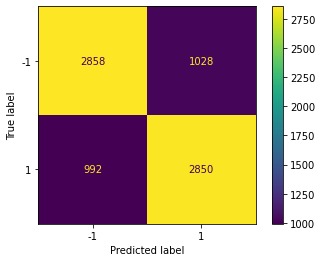

In [34]:
gnb = GaussianNB()

gnb.fit(X_train, y_train)
predictions = gnb.predict(X_test)
cm = confusion_matrix(y_test, predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=gnb.classes_)
disp.plot()

In [35]:
gnb_accuracy = cross_val_score(gnb, X_pca, y, cv=cv, scoring='accuracy')
gnb_f1 = cross_val_score(gnb, X_pca, y, cv=cv, scoring=f1_scorer)

print(f'Gaussian Naive Bayes Accuracy: {gnb_accuracy.mean():.3f} (+/- {gnb_accuracy.std():.3f})')
print(f'Gaussian Naive Bayes F1: {gnb_f1.mean():.3f} (+/- {gnb_f1.std():.3f})')

Gaussian Naive Bayes Accuracy: 0.737 (+/- 0.005)
Gaussian Naive Bayes F1: 0.738 (+/- 0.003)


Below we tested the performance for Logistic Regression.

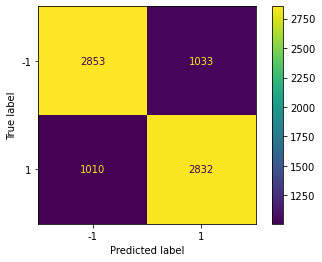

In [36]:
logreg = LogisticRegression(max_iter=1000)

logreg.fit(X_train, y_train)
predictions = logreg.predict(X_test)
cm = confusion_matrix(y_test, predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=logreg.classes_)
disp.plot()

In [37]:
lr_accuracy = cross_val_score(logreg, X_pca, y, cv=cv, scoring='accuracy')
lr_f1 = cross_val_score(logreg, X_pca, y, cv=cv, scoring=f1_scorer)

print(f'Logistic Regression Accuracy: {lr_accuracy.mean():.3f} (+/- {lr_accuracy.std():.3f})')
print(f'Logistic Regression F1: {lr_f1.mean():.3f} (+/- {lr_f1.std():.3f})')

Logistic Regression Accuracy: 0.736 (+/- 0.003)
Logistic Regression F1: 0.737 (+/- 0.002)


Below we tested the performance for SVM.

In [38]:
svc = SVC()

svm_accuracy = cross_val_score(svc, X_pca, y, cv=cv, scoring='accuracy')
svm_f1 = cross_val_score(svc, X_pca, y, cv=cv, scoring=f1_scorer)

print(f'Support Vector Machine Accuracy: {svm_accuracy.mean():.3f} (+/- {svm_accuracy.std():.3f})')
print(f'Support Vector Machine F1: {svm_f1.mean():.3f} (+/- {svm_f1.std():.3f})')

We will finally use Random Forest to see if we can improve the performance.

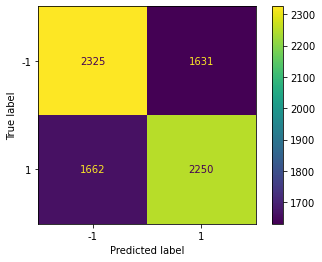

In [39]:
# Create a RandomForestClassifier object with the desired parameters
rfc = RandomForestClassifier()

rfc.fit(X_train, y_train)
predictions = rfc.predict(X_test)
cm = confusion_matrix(y_test, predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=rfc.classes_)
disp.plot()

In [ ]:
rfc_accuracy = cross_val_score(rfc, X_pca, y, cv=cv, scoring='accuracy')
rfc_f1 = cross_val_score(rfc, X_pca, y, cv=cv, scoring=f1_scorer)

print(f'Logistic Regression Accuracy: {rfc_accuracy.mean():.3f} (+/- {rfc_accuracy.std():.3f})')
print(f'Logistic Regression F1: {rfc_f1.mean():.3f} (+/- {rfc_f1.std():.3f})')